Simple conway game of life rules on GPU

In [11]:
import torch
import numpy as np
import os

import matplotlib.pyplot as plt

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "caching_allocator"

In [95]:
torch.cuda.is_available()
cuda = torch.device('cuda')
cpu = torch.device('cpu')


In [96]:
canvas = torch.randint(0, 2, (100, 100), device=cuda, dtype=torch.int)

In [97]:
canvas.to(cpu)

tensor([[0, 0, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 1, 1],
        [1, 1, 1,  ..., 1, 1, 0],
        ...,
        [1, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 0, 1, 0],
        [0, 1, 1,  ..., 0, 1, 0]], dtype=torch.int32)

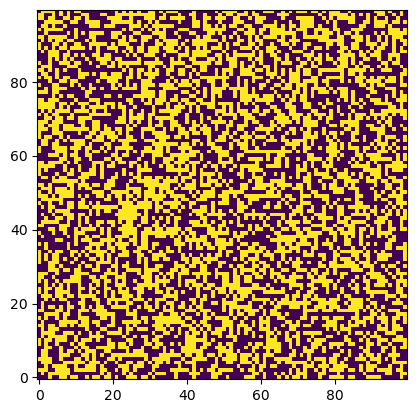

In [98]:
plt.imshow(canvas.to(cpu), origin="lower")

In [99]:
torch.roll(canvas, -1, dims=0)

tensor([[0, 1, 0,  ..., 0, 1, 1],
        [1, 1, 1,  ..., 1, 1, 0],
        [0, 0, 1,  ..., 0, 1, 0],
        ...,
        [1, 1, 0,  ..., 0, 1, 0],
        [0, 1, 1,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0]], device='cuda:0', dtype=torch.int32)

In [47]:
canvas.device

device(type='cuda', index=0)

In [177]:
def calc_shifted(intensor):
    """shifted up, down, left, right"""
    out_size = (*tuple(intensor.shape), 4)
    output = torch.zeros(out_size, dtype=intensor.dtype, device=intensor.device)   
    output[:, :, 0] = torch.roll(intensor, shifts=-1, dims=0)
    output[:, :, 1] = torch.roll(intensor, shifts=1, dims=0)
    output[:, :, 2] = torch.roll(intensor, shifts=-1, dims=1)
    output[:, :, 3] = torch.roll(intensor, shifts=1, dims=1)
    return output
    
def calc_unshifted(intensor):
    out_size = (*tuple(intensor.shape), 4)
    output = torch.zeros(out_size, dtype=intensor.dtype, device=intensor.device)   
    output[:, :, 0] = torch.roll(intensor, shifts=1, dims=0)
    output[:, :, 1] = torch.roll(intensor, shifts=-1, dims=0)
    output[:, :, 2] = torch.roll(intensor, shifts=1, dims=1)
    output[:, :, 3] = torch.roll(intensor, shifts=-1, dims=1)
    return output

def center_cut(intensor):
    output = intensor[1:-1, 1:-1]
    return output
    
def center_cut_dd(intensor):
    output = intensor[1:-1, 1:-1, :]
    return output
    
def null_edges(intensor):
    intensor[0, :] = 0
    intensor[:, 0] = 0
    intensor[:, -1] = 0
    intensor[-1, :] = 0
    return intensor


def pad(canvas):
    """Warning, torch pad has a really strange syntax"""
    arr = torch.nn.functional.pad(canvas, (1, 1, 1, 1), mode="constant", value=0)
    return arr

In [178]:
canvas = torch.randint(0, 2, (10, 10), device=cuda, dtype=torch.int)

In [179]:
canvas.shape

torch.Size([10, 10])

In [180]:
pad(canvas).shape

torch.Size([12, 12])

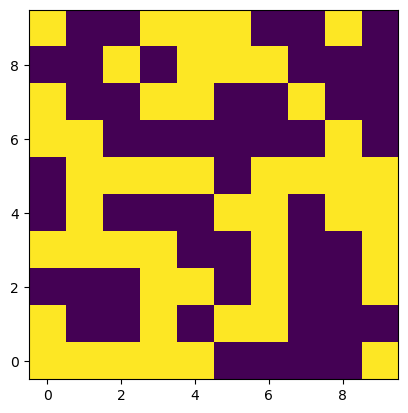

In [181]:
plt.imshow(canvas.to(cpu), origin="lower")

In [184]:
tens = center_cut_dd(calc_shifted(pad(canvas)))

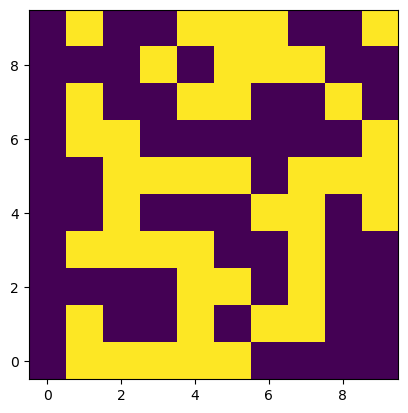

In [194]:
plt.imshow(tens[:, :, 3].to(cpu), origin="lower")

In [ ]:
center_cut_dd(calc_shifted(pad(canvas)))

In [175]:
shifted = calc_shifted(pad(canvas))

In [176]:
shifted.shape

torch.Size([12, 12, 4])

In [ ]:
plt.imshow(pad(canvas).to(cpu), origin="lower")